In [1]:
import glob
from io import open
import pandas as pd
from pandas import DataFrame as df
from os import path
import re
import gensim
import numpy as np
from collections import Counter

In [2]:
import nltk

In [3]:
from nltk import word_tokenize

In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
from tools import get_psycinfo_database

In [13]:
words_df = get_psycinfo_database()

data/PsycInfo/csv/multiculturalism_3.csv 1000
data/PsycInfo/csv/multiculturalism_6.csv 1624
data/PsycInfo/csv/multicultural_5.csv 1000
data/PsycInfo/csv/interracial_2.csv 1246
data/PsycInfo/csv/multiculturalism_2.csv 1000
data/PsycInfo/csv/multiethnic_1.csv 1000
data/PsycInfo/csv/multicultural_9.csv 1000
data/PsycInfo/csv/polyethnic.csv 7
data/PsycInfo/csv/multiculturalism_5.csv 1000
data/PsycInfo/csv/bicultural.csv 1784
data/PsycInfo/csv/multiculturalism_1.csv 1000
data/PsycInfo/csv/multicultural_10.csv 1000
data/PsycInfo/csv/polyculturalism.csv 13
data/PsycInfo/csv/biethnic.csv 42
data/PsycInfo/csv/other race.csv 738
data/PsycInfo/csv/other ethnicity.csv 87
data/PsycInfo/csv/mixed race.csv 551
data/PsycInfo/csv/interracial_1.csv 1500
data/PsycInfo/csv/polycultural.csv 14
data/PsycInfo/csv/multicultural_3.csv 1000
data/PsycInfo/csv/biracial.csv 882
data/PsycInfo/csv/multicultural_4.csv 1000
data/PsycInfo/csv/multiculturalism_4.csv 1000
data/PsycInfo/csv/mixed ethnicity.csv 99
data/Psy

In [14]:
words_df.head()

,Abstract,Accession Number,Author(s),Type of Book,PsycINFO Classification Code,Conference,Document Type,Grant/Sponsorship,Key Concepts,Institution,...,Population Group,Publication Status,Publication Type,Publisher,Cited References,Title,Tests & Measures,Volume,Date,Term
0,(from the chapter) This chapter provides Infor...,Book: 2011-12790-011.,"Abakoui, Roki\n\nSimmons, Rosemary E",Handbook/Manual,Professional Psychological & Health Personnel ...,NaN,Chapter,NaN,"multicultural counseling, cultural competency,...","Abakoui, Roki: Northwestern University, Counse...",...,Human,NaN,Book\n\nEdited Book,John Wiley & Sons Inc; US,"Abakoui, R. A. (1998). Effects of weight statu...",Sizeism: An unrecognized prejudice. [References].,NaN,NaN,2010,multiculturalism
1,(from the chapter) The purpose of this chapter...,Book: 2011-12790-010.,"Schreier, Barry A\n\nDudley Lassiter, Kim",Handbook/Manual,Professional Psychological & Health Personnel ...,NaN,Chapter,NaN,"multicultural counseling, cultural competency,...","Schreier, Barry A.: University of Connecticut,...",...,Human,NaN,Book\n\nEdited Book,John Wiley & Sons Inc; US,"Alexander, C. J. (1997). Growth and intimaty f...",Competencies for working with sexual orientati...,NaN,NaN,2010,multiculturalism
2,(from the chapter) This chapter provides an ov...,Book: 2011-12790-009.,"Sanchez, Delida\n\nDavis, Claytie III",Handbook/Manual,Professional Psychological & Health Personnel ...,NaN,Chapter,NaN,"multicultural counseling competency, racial co...","Sanchez, Delida: Brooklyn College, City Univer...",...,Human,NaN,Book\n\nEdited Book,John Wiley & Sons Inc; US,American Psychological Association. (2003). Gu...,Becoming a racially competent therapist. [Refe...,NaN,NaN,2010,multiculturalism
3,(from the chapter) There is a growing number o...,Book: 2011-12790-008.,"Dixon-Peters, Aisha",Handbook/Manual,Professional Psychological & Health Personnel ...,NaN,Chapter,NaN,"multicultural counseling, cultural competency,...","Dixon-Peters, Aisha: California State Universi...",...,Human,NaN,Book\n\nEdited Book,John Wiley & Sons Inc; US,"AhnAllen, J. M., Suyemoto, K. L., & Carter, A....",Developing multicultural competency in clinica...,NaN,NaN,2010,multiculturalism
4,(from the chapter) The examination of the diff...,Book: 2011-12790-007.,"Stevens, Mark A\n\nEnglar-Carlson, Matt",Handbook/Manual,Professional Psychological & Health Personnel ...,NaN,Chapter,NaN,"cultural competency, multiculturalism, psychot...","Stevens, Mark A.: California State University ...",...,Human. Male,NaN,Book\n\nEdited Book,John Wiley & Sons Inc; US,"Ackerman, S. J., & Hilsenroth, M. J. (2003). A...",Psychotherapy with men: Building practice comp...,NaN,NaN,2010,multiculturalism


## Generate Corpora

In [128]:
words_to_replace = {"/":"-", "bi-ethnic": "biethnic", "bi-racial": "biracial", 
                    "mono-ethnic": "monoethnic", "poly-ethnic": "polyethnic", 
                    "mono-racial": "monoracial", "multi-racial": "multiracial",
                    "inter-racial": "interracial", "mono-cultural": "monocultural",
                    "bi-cultural": "bicultural", "multi-cultural": "multicultural",
                    "other ethnicity":"other-ethnicity", "other race": "other-race", 
                    "mixed race": "mixed-race", "mixed ethnicity": "mixed-ethnicity"}

In [42]:
abstract_text = [[x_.lower() for x_ in word_tokenize(x)] for x in words_df.Abstract.fillna("").values]

In [43]:
abstract_text[0][:10]

['the',
 'examination',
 'of',
 'an',
 'afro-brazilian',
 'martial',
 'art',
 ',',
 'capoeira',
 ',']

In [44]:
print("Number of Abstracts", len(abstract_text))
print("Number of words", sum(len(x) for x in abstract_text))

Number of Abstracts 28304
Number of words 5986261


In [45]:
model = gensim.models.Word2Vec(sentences=abstract_text, size=32, window=5, min_count=2, sample=0,
                               workers=10, hs=1, sg=1, cbow_mean=0)

In [47]:
model.most_similar_cosmul("multicultural")

[('counseling', 0.9512667059898376),
 ('counselling', 0.9383204579353333),
 ('advocacy', 0.9331955909729004),
 ('training', 0.9317465424537659),
 ('sport', 0.9286409020423889),
 ('sub-fields', 0.9285836815834045),
 ('culturally-skilled', 0.9274426698684692),
 ('queering', 0.9263074994087219),
 ('diversity', 0.9248067736625671),
 ('cross-cultural', 0.9238433837890625)]

In [48]:
model.most_similar_cosmul("biracial")

[('multiracial', 0.9622998237609863),
 ('mixed-race', 0.9334530234336853),
 ('mixed-heritage', 0.9233209490776062),
 ('black/white', 0.9202012419700623),
 ('biethnic', 0.9181261658668518),
 ('asian-white', 0.9160805344581604),
 ('young', 0.9129253029823303),
 ('women-women', 0.9126173853874207),
 ('self-label', 0.9118567109107971),
 ('bi-racial', 0.9112046360969543)]

In [49]:
model.most_similar_cosmul("monoracial")

[('single-race', 0.9389999508857727),
 ('minority/white', 0.9284915328025818),
 ('asian-white', 0.9261074066162109),
 ('monoethnic', 0.9253686666488647),
 ('multiracial', 0.9207021594047546),
 ('mixed-race', 0.9205929636955261),
 ('self-identification', 0.9203444123268127),
 ('black/white', 0.9167036414146423),
 ('mixed-raced', 0.9164007902145386),
 ('knowable', 0.9116670489311218)]

In [115]:
model.most_similar_cosmul("bicultural", topn=10)

[('monocultural', 0.9114831686019897),
 ('self-identity', 0.90879887342453),
 ('well-functioning', 0.9075254201889038),
 ('marginal', 0.905578076839447),
 ('tricultural', 0.8998859524726868),
 ('identity', 0.8990780711174011),
 ('acculturation', 0.8976826667785645),
 ('mismatching', 0.8970291018486023),
 ('spiritual/religious/nonreligious', 0.8952893614768982),
 ('singular-majority', 0.8895629644393921)]

## Hierchical Clustering

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [51]:
words = ['monocultural', 'monoracial', 'bicultural', 'biracial', 'biethnic', 'interracial',
        'multicultural', 'multiracial', 'multiethnic', 'polycultural', 'polyracial', 'polyethnic',
        'mixed race', 'mixed ethnicity', 'other race', 'other ethnicity', 'multiculturalism', 'polyculturalism',
         'cultural pluralism']

In [123]:
expansion = []
for w in words:
    if w in model:
        expansion.extend([x for x,y in model.most_similar(w, topn=50)])
counter = Counter(expansion)
expansion = [x for x, y in counter.items() if y > 2]

In [124]:
y = []
X = []
for w in set(words + expansion):
    if w in model:
        X.append(model[w])
        y.append(w)
X = np.asarray(X)
X = (X.T / np.linalg.norm(X, axis=1)).T

In [125]:
X.shape

(33, 32)

In [126]:
Z = linkage(X, 'ward')

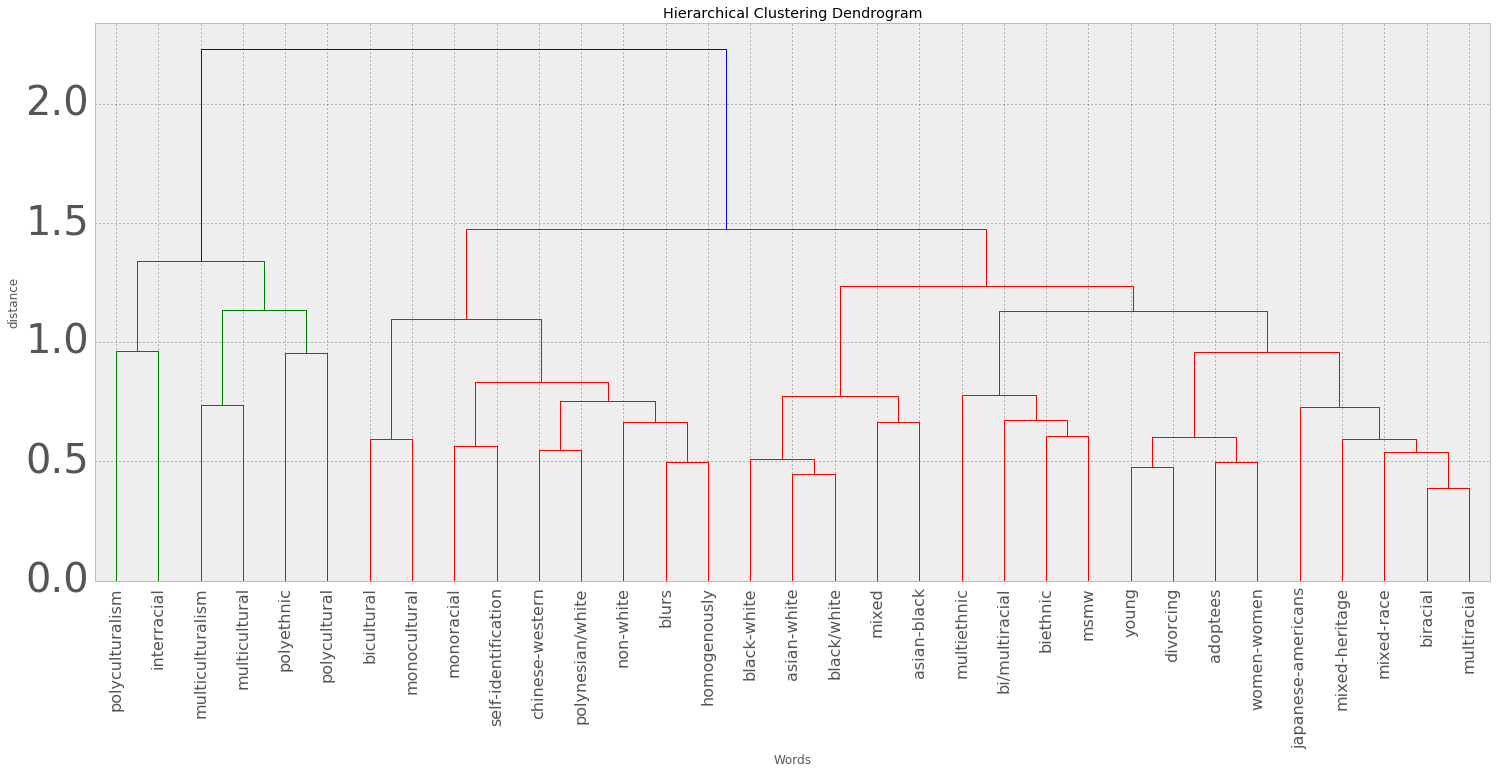

In [127]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('distance')
_ = dendrogram(Z, labels=y, leaf_rotation=90., leaf_font_size=16.)

## TODOs

1. Foo
1. Bar
